Importing necessary libraries first

In [1]:
import pandas as pd
import string 
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm 
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('./drive/MyDrive/Capstone/tvd_script.csv')

In [3]:
df.drop(columns="Unnamed: 0", inplace = True)

Basic inspection of the data

In [4]:
df.head()

,character,line
0,MAN,"For over a century, I have lived in secret; h..."
1,MAN,"An hour's drive to hear that crap. You know, ..."
2,GIRL,He wasn't that bad.
3,MAN,He sounded like James Blunt.
4,GIRL,What's wrong with that?


There are two colomuns, character and their line

There are 45551 total rows/ lines.

In [5]:
df.shape

(45551, 2)

In [6]:
#df['character'].unique()

In [7]:
#change charcter name to lower
df['character'] = df['character'].str.lower()

In [8]:
df['character'] = [str(i).partition('(')[0] for i in df.character]

In [9]:
df['character'].nunique()

577

Removing characters with less than 30 lines.

In [10]:
v = df.character.value_counts()
df = df[df.character.isin(v.index[v.gt(30)])]

In [11]:
df['character'].nunique()

98

In [12]:
df['character'].unique()

array(['man', 'girl', 'stefan', 'elena', 'jenna', 'jeremy', 'bonnie',
       'caroline', 'elena ', 'tyler', 'vicki', 'matt', 'stefan ', 'zach',
       'tanner', 'damon', 'logan', 'sheriff forbes', 'grams', 'katherine',
       'sheriff', 'vicky', 'woman', 'lexi', 'damon ', 'bonnie ', 'alaric',
       'anna', 'ben', 'pearl', 'giuseppe', 'kelly', 'isobel', 'carol',
       'frederick', 'trevor', 'john', '', 'katherine/elena', 'mason',
       'aimee', 'liz', 'sarah', 'lucy', 'rose', 'elijah', 'luka', 'jonas',
       'jules', 'brady', 'andie', 'klaus/alaric', 'alaric/klaus', 'klaus',
       'bill', 'gloria', 'rebekah', 'mikael', 'sheila', 'esther',
       'meredith', 'abby', 'jamie', 'kol', 'finn', 'sage', 'connor',
       'april', 'haley', 'shane', 'rudy', 'vaughn', 'silas', 'marcel',
       'jesse', 'nadia', '1.', 'tessa', 'jo', 'dr. maxfield', 'aaron',
       'amara', 'wes', 'enzo', 'sloan', 'liv', 'luke', 'markos', 'julian',
       'tripp', 'ivy', 'liam', 'kai', 'joshua', 'lily', 'nora',

In [13]:
#Who has the most lines in the show --- Damon, Elena, Stefan, Caroline, Bonnie
df['character'].value_counts()

damon       6737
elena       6710
stefan      5385
caroline    3311
bonnie      2284
            ... 
finn          33
jesse         32
amara         31
nora          31
brady         31
Name: character, Length: 98, dtype: int64

As we can see below, the characters with the most lines are Damon, Elena, Stefan, Caroline, Bonnie, Jeremet, Matt, Alaric, Katherine, and Tyler. This is interesting considering elena's character was dead seasons 6-8 (and is resurrected only to aapear in the last episode of the show). But Stefan, Caroline, and Bonnie appeared all 8 season (mostly). 

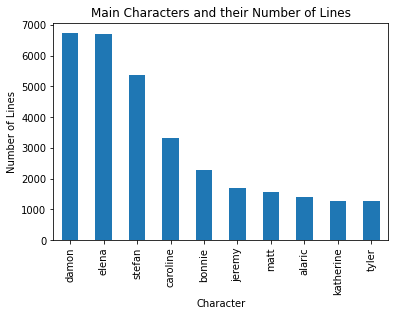

In [14]:
df.character.value_counts().sort_values(ascending = False).head(10).plot(kind = 'bar', 
                                                        xlabel='Character', 
                                                        ylabel='Number of Lines',
                                                        title = "Main Characters and their Number of Lines",
                                                        );

In [15]:
#removing new line characters
df['line'] = [str(text).replace('\n', ' ') for text in df.line]

In [16]:
def remove_punc(line): 
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  no_punc = ""
  for char in line:
    if char not in punctuations:
       no_punc = no_punc + char
  return no_punc

In [17]:
#remove punctuation
df['line'] = [remove_punc(str(text)) for text in df.line]

In [18]:
#lower case text
df['line'] = [text.lower() for text in df.line]

In [19]:
list_of_lines = df['line'].to_list()
corpus = ''

for line in list_of_lines:
  corpus += line

In [20]:
words = corpus.split()

In [21]:
damon_df = df[df['character'] == 'damon']
list_of_damon_lines = damon_df['line'].to_list()
damon_corpus = ''

for line in list_of_damon_lines:
  damon_corpus += line

damon_words = damon_corpus.split()

In [22]:
elena_df = df[df['character'] == 'elena']
list_of_elena_lines = elena_df['line'].to_list()
elena_corpus = ''

for line in list_of_elena_lines:
  elena_corpus += line

elena_words = elena_corpus.split()

In [23]:
stefan_df = df[df['character'] == 'stefan']
list_of_stefan_lines = stefan_df['line'].to_list()
stefan_corpus = ''

for line in list_of_stefan_lines:
  stefan_corpus += line

stefan_words = stefan_corpus.split()

In [24]:
caroline_df = df[df['character'] == 'caroline']
list_of_caroline_lines = caroline_df['line'].to_list()
caroline_corpus = ''

for line in list_of_caroline_lines:
  caroline_corpus += line

caroline_words = caroline_corpus.split()

In [25]:
bonnie_df = df[df['character'] == 'bonnie']
list_of_bonnie_lines = bonnie_df['line'].to_list()
bonnie_corpus = ''

for line in list_of_bonnie_lines:
  bonnie_corpus += line

bonnie_words = bonnie_corpus.split()

In [26]:
c = Counter(words)        
c.most_common(15)

[('you', 21688),
 ('i', 17904),
 ('to', 14765),
 ('the', 12606),
 ('a', 8895),
 ('and', 7455),
 ('that', 6873),
 ('it', 6633),
 ('me', 6510),
 ('of', 5546),
 ('what', 4976),
 ('is', 4791),
 ('im', 4542),
 ('in', 4155),
 ('this', 3913)]

We can see here that the most commonly occuring words here don't really tell us anaythig as they are common english words, so, I'll remove stop words and then find the most common words. 

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
#remove stop words
clean_words = [word for word in words if word.lower() not in stopwords.words('english')]
clean_text = ' '.join(clean_words)

In [29]:
damon_clean_words = [word for word in damon_words if word.lower() not in stopwords.words('english')]
damon_clean_text = ' '.join(damon_clean_words)

elena_clean_words = [word for word in elena_words if word.lower() not in stopwords.words('english')]
elena_clean_text = ' '.join(elena_clean_words)

stefan_clean_words = [word for word in stefan_words if word.lower() not in stopwords.words('english')]
stefan_clean_text = ' '.join(stefan_clean_words)

caroline_clean_words = [word for word in caroline_words if word.lower() not in stopwords.words('english')]
caroline_clean_text = ' '.join(caroline_clean_words)

bonnie_clean_words = [word for word in bonnie_words if word.lower() not in stopwords.words('english')]
bonnie_clean_text = ' '.join(bonnie_clean_words)

In [30]:
c = Counter(clean_words)        
c.most_common(20)

[('im', 4542),
 ('know', 3831),
 ('dont', 3502),
 ('youre', 2791),
 ('get', 2298),
 ('want', 2017),
 ('well', 1910),
 ('elena', 1851),
 ('like', 1764),
 ('kll', 1720),
 ('damon', 1660),
 ('stefan', 1632),
 ('right', 1629),
 ('one', 1581),
 ('think', 1511),
 ('gonna', 1507),
 ('yeah', 1499),
 ('go', 1492),
 ('back', 1452),
 ('going', 1421)]

In [31]:
damon_c = Counter(damon_clean_words)        
damon_c.most_common(20)

[('know', 587),
 ('im', 584),
 ('dont', 535),
 ('youre', 481),
 ('well', 449),
 ('get', 439),
 ('elena', 424),
 ('stefan', 373),
 ('gonna', 329),
 ('want', 320),
 ('kll', 311),
 ('one', 282),
 ('back', 262),
 ('like', 251),
 ('go', 241),
 ('think', 230),
 ('right', 229),
 ('come', 226),
 ('little', 224),
 ('yeah', 220)]

In [32]:
elena_c = Counter(elena_clean_words)        
elena_c.most_common(20)

[('im', 739),
 ('know', 583),
 ('dont', 545),
 ('stefan', 531),
 ('damon', 477),
 ('youre', 411),
 ('get', 293),
 ('gonna', 277),
 ('want', 275),
 ('cant', 274),
 ('going', 269),
 ('ok', 267),
 ('like', 249),
 ('kll', 230),
 ('go', 229),
 ('back', 222),
 ('bonnie', 218),
 ('think', 218),
 ('right', 214),
 ('need', 205)]

In [33]:
stefan_c = Counter(stefan_clean_words)        
stefan_c.most_common(20)

[('know', 537),
 ('im', 517),
 ('dont', 433),
 ('elena', 396),
 ('damon', 356),
 ('youre', 331),
 ('right', 323),
 ('get', 313),
 ('well', 279),
 ('want', 260),
 ('yeah', 224),
 ('kll', 220),
 ('go', 210),
 ('gonna', 203),
 ('hey', 202),
 ('think', 199),
 ('need', 179),
 ('back', 178),
 ('thats', 174),
 ('one', 171)]

In [34]:
caroline_c = Counter(caroline_clean_words)        
caroline_c.most_common(20)

[('im', 397),
 ('know', 317),
 ('dont', 288),
 ('youre', 235),
 ('elena', 185),
 ('stefan', 177),
 ('well', 177),
 ('get', 172),
 ('ok', 160),
 ('oh', 155),
 ('want', 149),
 ('yeah', 146),
 ('like', 146),
 ('going', 146),
 ('tyler', 145),
 ('think', 134),
 ('go', 131),
 ('hey', 115),
 ('gonna', 111),
 ('mom', 111)]

In [35]:
bonnie_c = Counter(bonnie_clean_words)        
bonnie_c.most_common(20)

[('im', 244),
 ('know', 204),
 ('dont', 202),
 ('get', 115),
 ('youre', 114),
 ('back', 110),
 ('cant', 109),
 ('want', 102),
 ('elena', 98),
 ('spell', 92),
 ('jeremy', 82),
 ('go', 79),
 ('damon', 79),
 ('like', 77),
 ('think', 77),
 ('need', 75),
 ('ok', 72),
 ('right', 68),
 ('yeah', 68),
 ('kll', 68)]

These are more telling. I'm not surprised that "elena" "kill" "damon" and "stefan" are one of the most commonly occuring words

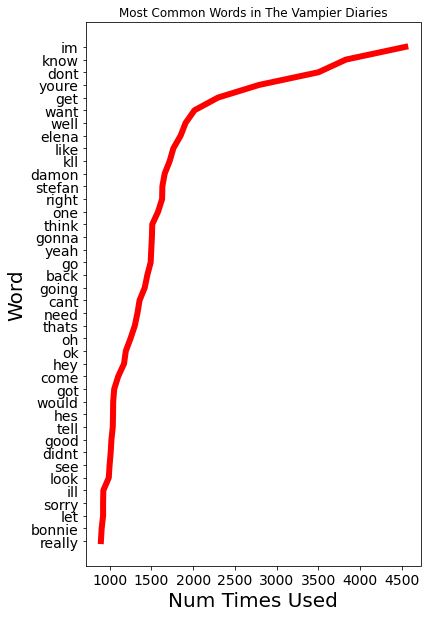

In [36]:
frequency_dist = nltk.FreqDist(clean_words)
word_dict = sorted(((count, word) for (word,count) in frequency_dist.items()))#, reverse=True)
counts, word = zip(*word_dict) # unpack a list of pairs into two tuples
import matplotlib.pyplot as plt
num_to_show = 40
plt.figure(figsize=[6,10])
plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=6,c='r')
plt.ylabel('Word',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Most Common Words in The Vampier Diaries")
plt.xlabel('Num Times Used',fontsize=20)
plt.xticks(fontsize=14)
plt.show()

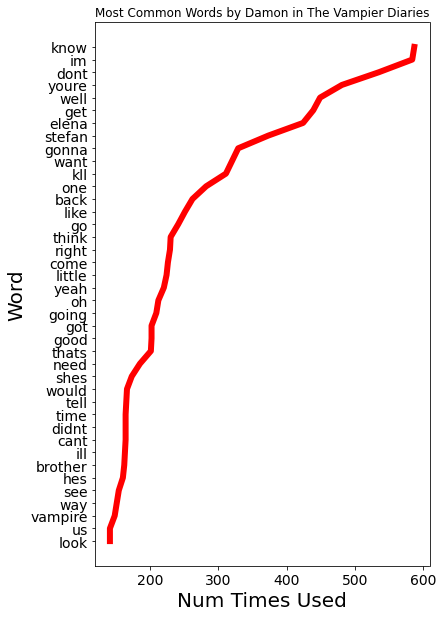

In [37]:
frequency_dist = nltk.FreqDist(damon_clean_words)
word_dict = sorted(((count, word) for (word,count) in frequency_dist.items()))#, reverse=True)
counts, word = zip(*word_dict) # unpack a list of pairs into two tuples
import matplotlib.pyplot as plt
num_to_show = 40
plt.figure(figsize=[6,10])
plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=6,c='r')
plt.ylabel('Word',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Most Common Words by Damon in The Vampier Diaries")
plt.xlabel('Num Times Used',fontsize=20)
plt.xticks(fontsize=14)
plt.show()

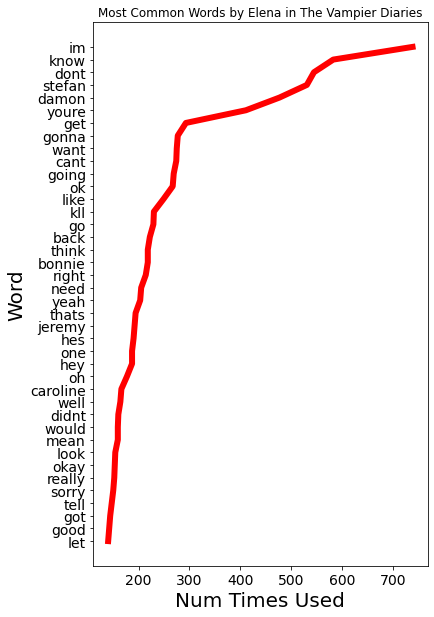

In [38]:
frequency_dist = nltk.FreqDist(elena_clean_words)
word_dict = sorted(((count, word) for (word,count) in frequency_dist.items()))#, reverse=True)
counts, word = zip(*word_dict) # unpack a list of pairs into two tuples
import matplotlib.pyplot as plt
num_to_show = 40
plt.figure(figsize=[6,10])
plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=6,c='r')
plt.ylabel('Word',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Most Common Words by Elena in The Vampier Diaries")
plt.xlabel('Num Times Used',fontsize=20)
plt.xticks(fontsize=14)
plt.show()

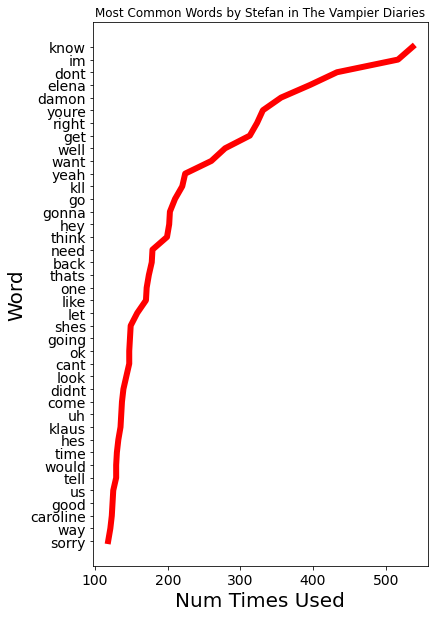

In [39]:
frequency_dist = nltk.FreqDist(stefan_clean_words)
word_dict = sorted(((count, word) for (word,count) in frequency_dist.items()))#, reverse=True)
counts, word = zip(*word_dict) # unpack a list of pairs into two tuples
import matplotlib.pyplot as plt
num_to_show = 40
plt.figure(figsize=[6,10])
plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=6,c='r')
plt.ylabel('Word',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Most Common Words by Stefan in The Vampier Diaries")
plt.xlabel('Num Times Used',fontsize=20)
plt.xticks(fontsize=14)
plt.show()

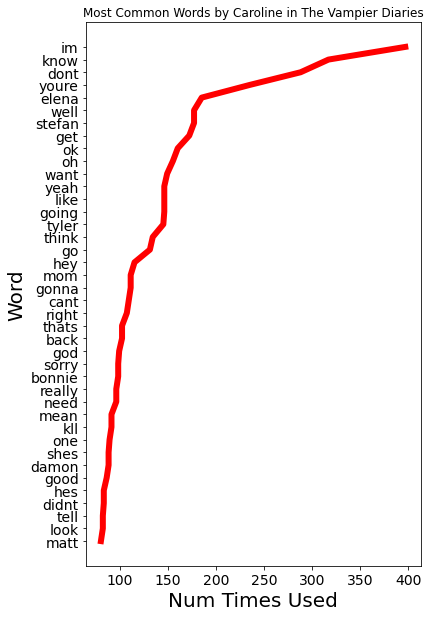

In [40]:
frequency_dist = nltk.FreqDist(caroline_clean_words)
word_dict = sorted(((count, word) for (word,count) in frequency_dist.items()))#, reverse=True)
counts, word = zip(*word_dict) # unpack a list of pairs into two tuples
import matplotlib.pyplot as plt
num_to_show = 40
plt.figure(figsize=[6,10])
plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=6,c='r')
plt.ylabel('Word',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Most Common Words by Caroline in The Vampier Diaries")
plt.xlabel('Num Times Used',fontsize=20)
plt.xticks(fontsize=14)
plt.show()

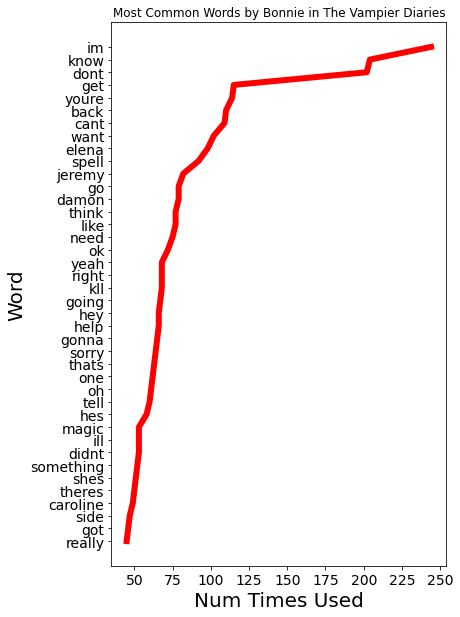

In [41]:
frequency_dist = nltk.FreqDist(bonnie_clean_words)
word_dict = sorted(((count, word) for (word,count) in frequency_dist.items()))#, reverse=True)
counts, word = zip(*word_dict) # unpack a list of pairs into two tuples
import matplotlib.pyplot as plt
num_to_show = 40
plt.figure(figsize=[6,10])
plt.plot(counts[-num_to_show:], word[-num_to_show:],lw=6,c='r')
plt.ylabel('Word',fontsize=20)
plt.yticks(fontsize=14)
plt.title("Most Common Words by Bonnie in The Vampier Diaries")
plt.xlabel('Num Times Used',fontsize=20)
plt.xticks(fontsize=14)
plt.show()

In [42]:
from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures
bigram_collocation = BigramCollocationFinder.from_words(clean_words) 
bigram_collocation.apply_freq_filter(3) 
bigram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 20)
bigram_collocation.score_ngrams(BigramAssocMeasures.likelihood_ratio)[:20]

[(('mystic', 'falls'), 3320.039741355297),
 (('im', 'sorry'), 3227.7147876183617),
 (('oh', 'god'), 2663.5570663904487),
 (('dont', 'know'), 2091.1122998653773),
 (('im', 'gonna'), 1684.239463439751),
 (('dont', 'want'), 1398.6970533500034),
 (('last', 'night'), 919.0474936216558),
 (('whats', 'going'), 915.48535232028),
 (('sire', 'bond'), 898.2857070088501),
 (('youre', 'gonna'), 831.4999289397144),
 (('full', 'moon'), 812.0409769469545),
 (('let', 'go'), 806.501557198879),
 (('best', 'friend'), 688.2655683761612),
 (('im', 'going'), 677.3604768250045),
 (('little', 'bit'), 676.0663956194103),
 (('hey', 'hey'), 669.5093215969298),
 (('high', 'school'), 653.1151126019773),
 (('youre', 'going'), 623.7653084151568),
 (('ha', 'ha'), 608.3948806605607),
 (('make', 'sure'), 605.6927848118356)]

The show is set in "Mystic Falls", "I'm sorry", and "oh god" are the most common bigrams in the show.

# Modeling - Who Said It?

## SVM

In [43]:
df.columns

Index(['character', 'line'], dtype='object')

In [44]:
#only using main chars

mains = ['damon', 'elena', 'stefan', 'caroline', 'bonnie']

df = df.loc[df['character'].isin(mains)]

In [45]:
z = df['line']
y = df["character"]
z_train, z_test,y_train, y_test = train_test_split(z,y,test_size = 0.3)

In [46]:
cv = CountVectorizer()
features = cv.fit_transform(z_train)

In [47]:
model = svm.SVC()
model.fit(features,y_train)

SVC()

In [48]:
features_test = cv.transform(z_test)
print("Accuracy: {}".format(model.score(features_test,y_test)))

Accuracy: 0.38122526947741847


In [49]:
param_grid = {'C': [0.1], 
              'gamma': [1],
              'kernel': ['linear']} 
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(features, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.386 total time=  33.7s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.386 total time=  33.7s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.387 total time=  33.7s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.388 total time=  33.8s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.383 total time=  33.7s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1], 'gamma': [1], 'kernel': ['linear']},
             verbose=3)

In [55]:
model.support_vectors_.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
features

<17098x8740 sparse matrix of type '<class 'numpy.int64'>'
	with 165249 stored elements in Compressed Sparse Row format>